# Gaussian Process

__Overview__: This lab is meant as an introduction to Gaussian Process regression.

__Goals__: Students should:

1. Be able to implement the a Gaussian Process with a square exponential kernel.
2. Gain intuition for how the kernel function parameters affect the prior.
3. Gain intuition for how the kernel function parameters affect the prediction with and without noise.
4. Be able to implement the data likelihood given the kernel parameters.
5. Gain inuition for the tradeoff between fitting the data and model complexity.

In [1]:
import functools
from typing import Any, Optional, Tuple

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

## Kinematics Dataset
We will start from a pre-generated dataset for this lab. This data comes from a simple kinemtaics simulation that follows these equations:

$$
X_t = t * \sin\left( \frac{2 \pi t}{P} \right) + W_t
$$

where $T$ is a parameter of our system and $W_t$ is white-noise with $W_t \sim \mathcal{N}(0, \sigma_w^2$). This equation is the product of a periodic function and a linear function, so it will be interesting to see how different kernel assumptions for our Gaussian Process adapt to the data. Our goal is to infer the true trajectory of the object from the noisy data.

We will generate a dataset where $P = 0.2$ and $\sigma_w = 0.5$.

In [2]:
# Let's generate the kinematics dataset.
x = np.linspace(start=0, stop=10, num=1000).reshape(-1, 1)
f_true = 0.5 * np.squeeze(x * np.sin(x / 0.2))

rng = np.random.seed(2)
obs_indices = np.random.choice(np.arange(f_true.size), size=10, replace=False)
x_obs, f_obs = x[obs_indices], f_true[obs_indices]
y_obs = f_obs + np.random.normal(loc=0.0, scale=0.5, size=f_obs.shape)

## Part I: Implementing the Base Gaussian Process Class

To compare different kernel you will need to implement a GP class that:

1. Implement the calculation of the K matrix.
2. Store the data and the inverse K matrix for prediction.
3. Implement the mean and covariance prediction functions.
4. Implement calculation of likelihood of observations given kernel parameters.

We will assume that $\mu(t) = 0$ for our GP.


In [3]:
class GaussianProcess:
    """Class that implements a Gaussian Process.
    
    Args:
        kernel_function: Function for calculating kappa(x,x').
    """
    def __init__(self, kernel_function: Any):
        """Initialize our class."""
        # Save the vectorized kernel function. Your kernel function
        # will take as input two scalar, but the vectorized function needs
        # to take in two arrays, one of length $m$ and one of length $n$,
        # and return a mxn matrix. We use one call of numpy.vectorize and take 
        # advantage of the signature options.
        self._kernel_function = (
            np.vectorize(kernel_function, 
                         signature='(),(m)->()'
                        )
        )

        # Initialize to None so we know to predict the prior to start.
        self.k_matrix_inv = None
        self.observed_x = None
        self.observed_y = None

    def calc_k_matrix(self, x_rows: np.ndarray, x_cols: np.ndarray) -> np.ndarray:
        """Calculate the K matrix at the given positions.

        Args:
            x_rows: X-position for the rows.
            x_cols: X-position for the columns.

        Returns:
            K(x_rows,x_cols) matrix.
        """
        # TODO: All this function needs to do is call our vectorized kernel function
        return self._kernel_function(x_rows, x_cols)
        

    def set_observations(self, observed_x: np.ndarray, observed_y: np.ndarray, 
                         sigma_w: float):
        """Store the x and y that have been observed.

        Args:
            observed_x: Observed input points x.
            observed_y: Observed (noisy) outputs y.
            sigma_w: Observational noise standard deviation.

        Notes:
            Modifies internal variables.
        """
        # Save the observations.
        self.observed_x = observed_x
        self.observed_y = observed_y

        # TODO: Save the K matrix inverse with the noise included.
        self.k_matrix_inv = np.linalg.inv(self.calc_k_matrix(
            observed_x, observed_x
        ) + sigma_w**2 * np.eye(len(observed_x)))

    def predict(self, predict_x: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        """Predict the mean and covariance at given points.

        Args:
            predict_x: X-positions at which to make predictions.

        Returns:
            Mean and covariance matrix at the requested points.

        Notes:
            If no observations have been set, this will return the prior.
        """
        # TODO: Calculate the k_star_star matrix. 
        k_star_star_matrix = self.calc_k_matrix(predict_x, predict_x)

        # TODO: Start with the prior predictions
        mean_pred = np.zeros(len(predict_x))
        cov_pred = k_star_star_matrix
        # TODO: Correct for observed data if it exists.
        if self.observed_x is not None:
            # Calculate the k_star matrix. Use the saved k_matrix_inv for speed 
            # of computation.
            k_star_matrix = self.calc_k_matrix(self.observed_x, predict_x)

            # Update mean and covariance prediction.
            mean_pred += k_star_matrix.T @ (self.k_matrix_inv) @ (self.observed_y - np.zeros(len(self.observed_x)))
            cov_pred -= k_star_matrix.T @ self.k_matrix_inv @ k_star_matrix
        
        return mean_pred, cov_pred

    def sample_f(self, predict_x: np.ndarray, n_samples: Optional[int] = 1) -> np.ndarray:
        """Return samples of the function space at the desired points.

        Args:
            predict_x: X-positions at which to make predictions.
            n_samples: Number of function samples to draw.

        Returns:
            Samples of the function space outputs.
        """
        # Get the mean and covariance prediction from our function.
        mean_pred, cov_pred = self.predict(predict_x)

        # Draw samples.
        f_samples = np.zeros((n_samples, len(predict_x)))
        for i in range(len(f_samples)):
            f_samples[i] = multivariate_normal.rvs(mean=mean_pred, cov=cov_pred)

        return f_samples

    def log_likelihood(self) -> float:
        """Return the log likelihood of the data for the given kernel.

        Returns:
            Log likelihood of the data.
        """
        # TODO: Implement the log likelihood of the data.
        log_likelihood_calc = -0.5 * (self.observed_y.T @ self.k_matrix_inv @ self.observed_y) - 0.5 * np.linalg.slogdet(self.calc_k_matrix(self.observed_x, self.observed_x))[1] - (len(self.observed_x) / 2) * np.log(2 * np.pi)

        return log_likelihood_calc

In [4]:
# A few tests for our GP functions.
def test_kernel_function(x, x_prime):
    return np.exp(-np.sum(np.square(x - x_prime))/20)

gp_test = GaussianProcess(test_kernel_function)

x_test = np.linspace(0,10,4).reshape(-1, 1)

# Test the K matrix calculation.
k_matrix = gp_test.calc_k_matrix(x_test, x_test)
np.testing.assert_array_almost_equal(
    k_matrix,
    [[1.0, 0.573753, 0.108368, 0.006738],
     [0.573753, 1.0, 0.573753, 0.108368],
     [0.108368, 0.573753, 1.0, 0.573753],
     [0.006738, 0.108368, 0.573753, 1.0]]
)

# Test the predictions without observations.
mean_test, cov_test = gp_test.predict(x_test)
np.testing.assert_array_almost_equal(mean_test, np.zeros(4))
np.testing.assert_array_almost_equal(
    cov_test, 
    [[1.0, 0.573753, 0.108368, 0.006738],
     [0.573753, 1.0, 0.573753, 0.108368],
     [0.108368, 0.573753, 1.0, 0.573753],
     [0.006738, 0.108368, 0.573753, 1.0]]
)

# Test the predictions with observations
x_obs_test = np.linspace(0,10,4).reshape(-1, 1)
y_obs_test = np.linspace(5,50,4)
gp_test.set_observations(x_obs_test, y_obs_test, sigma_w=0.3)
mean_test, cov_test = gp_test.predict(x_test)
np.testing.assert_array_almost_equal(
    mean_test,
    np.array([5.346965, 18.628744, 34.861521, 46.078638])
)
np.testing.assert_array_almost_equal(
    cov_test, 
    [[ 0.078941,  0.007533, -0.003469,  0.001145],
     [ 0.007533,  0.073929,  0.009536, -0.003469],
     [-0.003469,  0.009536,  0.073929,  0.007533],
     [ 0.001145, -0.003469,  0.007533,  0.078941]]
)

# Test the log likelihood calculation.
np.testing.assert_almost_equal(
    gp_test.log_likelihood(),
    -1262.211359395657
)

AssertionError: 
Arrays are not almost equal to 7 decimals
 ACTUAL: np.float64(-1261.8615854949414)
 DESIRED: -1262.211359395657

## Part II: Comparing Kernels for our GP.

Let's compare how our different kernels impact our predictions. We can also test how different kernel values are favored by the model. We will:

1. Compare the prediction of a squared exponential and a cosine kernel.
2. See how different choices of the period for our cosine kernel impact the likelihood of the observed data.

The squared exponential kernel is given by:

$$
\kappa(x,x') = A * \exp\left(\frac{-(x-x')^2}{2 l^2}) \right)
$$

The cosine kernel is given by:

$$
\kappa(x,x') = A * \cos\left(\frac{|x-x'|}{P}\right)
$$


In [5]:
# First we need to implement our two kernels.
def cosine_kernel(x: float, x_prime: float, period: float, amplitude: float) -> float:
    """Cosine kernel function.

    Args:
        x: First x-position at which to calculate the kernel.
        x_prime: Second x-position at which to calculate the kernel.
        period: Period of the cosine kernel.
        amplitude: Amplitude of the cosine kernel.

    Returns:
        Kernel function value.
    """
    # TODO: Implement cosine kernel function.
    return amplitude * np.cos(np.abs(x - x_prime) / period)

def squared_exp_kernel(x: float, x_prime: float, length_scale: float, amplitude: float) -> float:
    """Cosine kernel function.

    Args:
        x: First x-position at which to calculate the kernel.
        x_prime: Second x-position at which to calculate the kernel.
        length_scale: Length scale of the squared exponential kernel.
        amplitude: Amplitude of the squared exponential kernel.

    Returns:
        Kernel function value.
    """
    # TODO: Implement cosine kernel function.
    return amplitude * np.exp(-0.5 * ((x - x_prime) ** 2) / (length_scale ** 2))

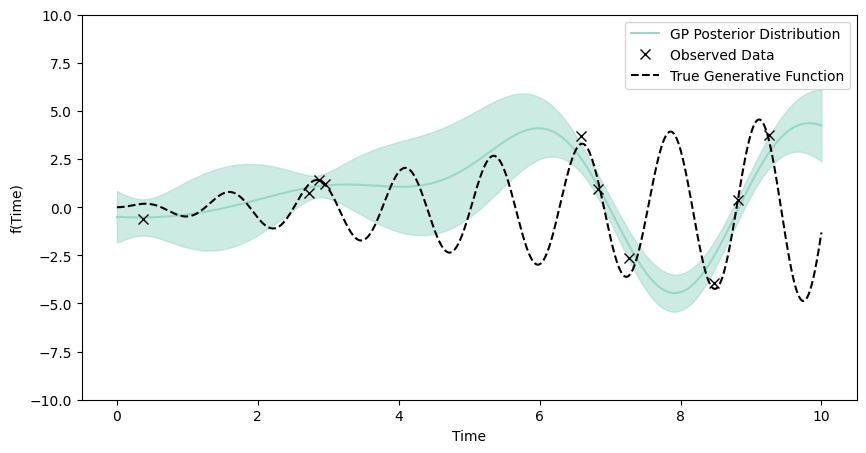

In [6]:
# First let's visualize the squared exponential kernel.
plt.figure(figsize=(10,5))

# TODO: Use functools.partial to set our kernel.
length_scale = 1.0
amplitude = 2.0
kernel_function = functools.partial(
    squared_exp_kernel,
    length_scale=length_scale,
    amplitude=amplitude
)
gp = GaussianProcess(kernel_function)
sigma_w = 0.5

gp.set_observations(x_obs, y_obs, sigma_w)
y_pred_mean, y_pred_cov = gp.predict(x)
y_pred_std = np.sqrt(np.diag(y_pred_cov))
plt.plot(x, y_pred_mean, color = '#99d8c9', label = 'GP Posterior Distribution')
plt.plot(x_obs, y_obs, 'x', color = 'k', label = 'Observed Data', markersize=7)
plt.plot(x, f_true, '--', color = 'k', label = 'True Generative Function')
plt.fill_between(x[:,0], y_pred_mean - 2 * y_pred_std, y_pred_mean + 2 * y_pred_std, 
                 color = '#99d8c9', alpha=0.5)
plt.legend()
plt.xlabel('Time')
plt.ylabel('f(Time)')
plt.ylim([-10,10])
plt.show()

__Why are these predictions doing poorly? Limit your answer to the form of the kernel and not the specific parameters values.__

In [ ]:
# TODO: Change this cell to markdown and write your answer to the question above.

raise ValueError('Answer the question.')

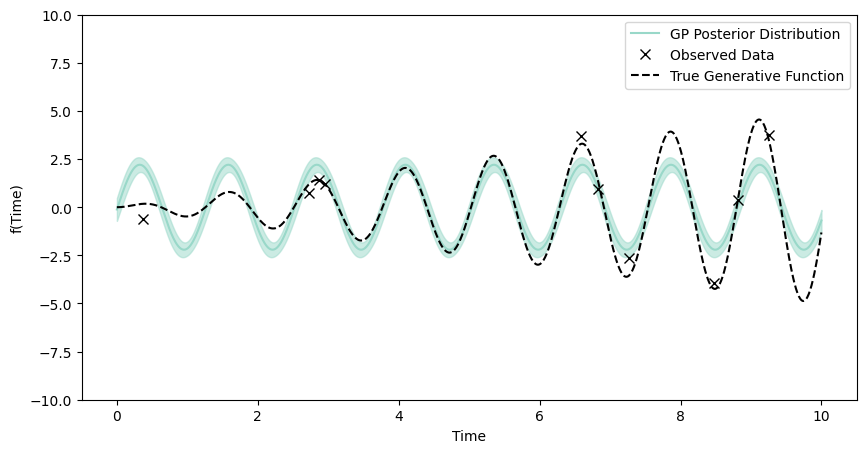

In [7]:
# Next let's visualize the cosine kernel.
plt.figure(figsize=(10,5))

# TODO: Use functools.partial to set our kernel.
period = 0.2
amplitude = 2.0
kernel_function = functools.partial(
    cosine_kernel,
    period=period,
    amplitude=amplitude
)
gp = GaussianProcess(kernel_function)
sigma_w = 0.5

gp.set_observations(x_obs, y_obs, sigma_w)
y_pred_mean, y_pred_cov = gp.predict(x)
y_pred_std = np.sqrt(np.diag(y_pred_cov))
plt.plot(x, y_pred_mean, color = '#99d8c9', label = 'GP Posterior Distribution')
plt.plot(x_obs, y_obs, 'x', color = 'k', label = 'Observed Data', markersize=7)
plt.plot(x, f_true, '--', color = 'k', label = 'True Generative Function')
plt.fill_between(x[:,0], y_pred_mean - 2 * y_pred_std, y_pred_mean + 2 * y_pred_std, 
                 color = '#99d8c9', alpha=0.5)
plt.legend()
plt.xlabel('Time')
plt.ylabel('f(Time)')
plt.ylim([-10,10])
plt.show()

__How are these new predictions better than the previous? Why are the predictions still limited? Limit your answer to the form of the kernel and not the specific parameters values.__

In [ ]:
# TODO: Change this cell to markdown and write your answer to the question above.

raise ValueError('Answer the question.')

In [8]:
# What if we combine our two kernels together?
def combined_kernel(x: float, x_prime: float, period_cosine: float, amplitude_cosine: float, 
                    length_scale: float, amplitude_se: float) -> float:
    """Sum of cosine and squared exponential kernel.

    Args:
        x: First x-position at which to calculate the kernel.
        x_prime: Second x-position at which to calculate the kernel.
        period_cosine: Period of the cosine kernel.
        amplitude_cosine: Amplitude of the cosine kernel.
        length_scale: Length scale of the squared exponential kernel.
        amplitude_se: Amplitude of the squared exponential kernel.

    Returns:
        Kernel function value.
    """
    # TODO: Implement the combination.
    return cosine_kernel(x, x_prime, period_cosine, amplitude_cosine) + squared_exp_kernel(x, x_prime, length_scale, amplitude_se)

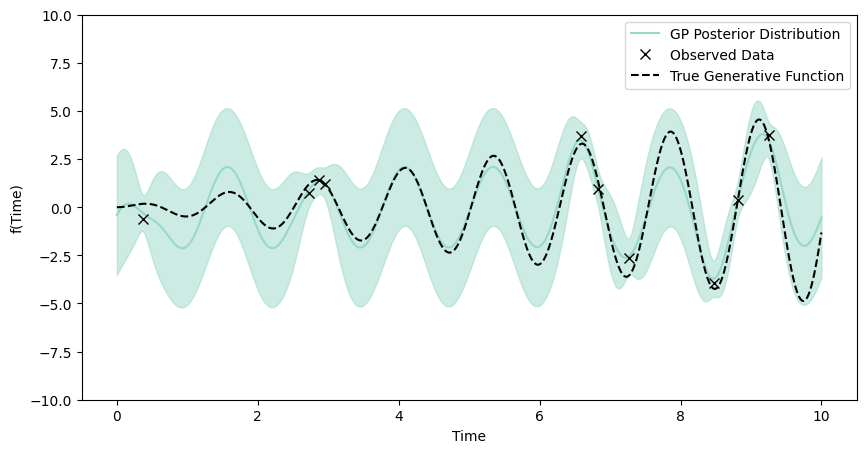

In [9]:
# Now let's visualize the combined kernel.
plt.figure(figsize=(10,5))

# TODO: Use functools.partial to set our kernel.
period_cosine = 0.2
amplitude_cosine = 2.0
length_scale = 0.2
amplitude_se = 2.0
kernel_function = functools.partial(
    combined_kernel,
    period_cosine=period_cosine,
    amplitude_cosine=amplitude_cosine,
    length_scale=length_scale,
    amplitude_se=amplitude_se
)
gp = GaussianProcess(kernel_function)
sigma_w = 0.5

gp.set_observations(x_obs, y_obs, sigma_w)
y_pred_mean, y_pred_cov = gp.predict(x)
y_pred_std = np.sqrt(np.diag(y_pred_cov))
plt.plot(x, y_pred_mean, color = '#99d8c9', label = 'GP Posterior Distribution')
plt.plot(x_obs, y_obs, 'x', color = 'k', label = 'Observed Data', markersize=7)
plt.plot(x, f_true, '--', color = 'k', label = 'True Generative Function')
plt.fill_between(x[:,0], y_pred_mean - 2 * y_pred_std, y_pred_mean + 2 * y_pred_std, 
                 color = '#99d8c9', alpha=0.5)
plt.legend()
plt.xlabel('Time')
plt.ylabel('f(Time)')
plt.ylim([-10,10])
plt.show()

__How are these new predictions better than the previous? Why might this be the case? Limit your answer to the form of the kernel and not the specific parameters values.__

In [ ]:
# TODO: Change this cell to markdown and write your answer to the question above.

raise ValueError('Answer the question.')

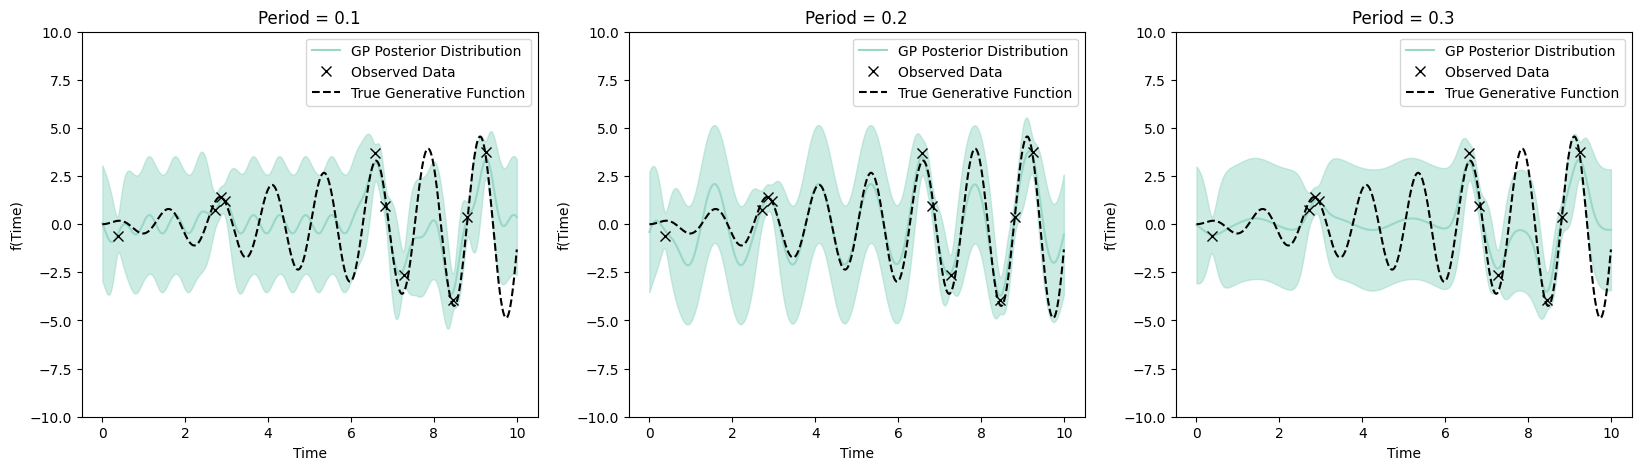

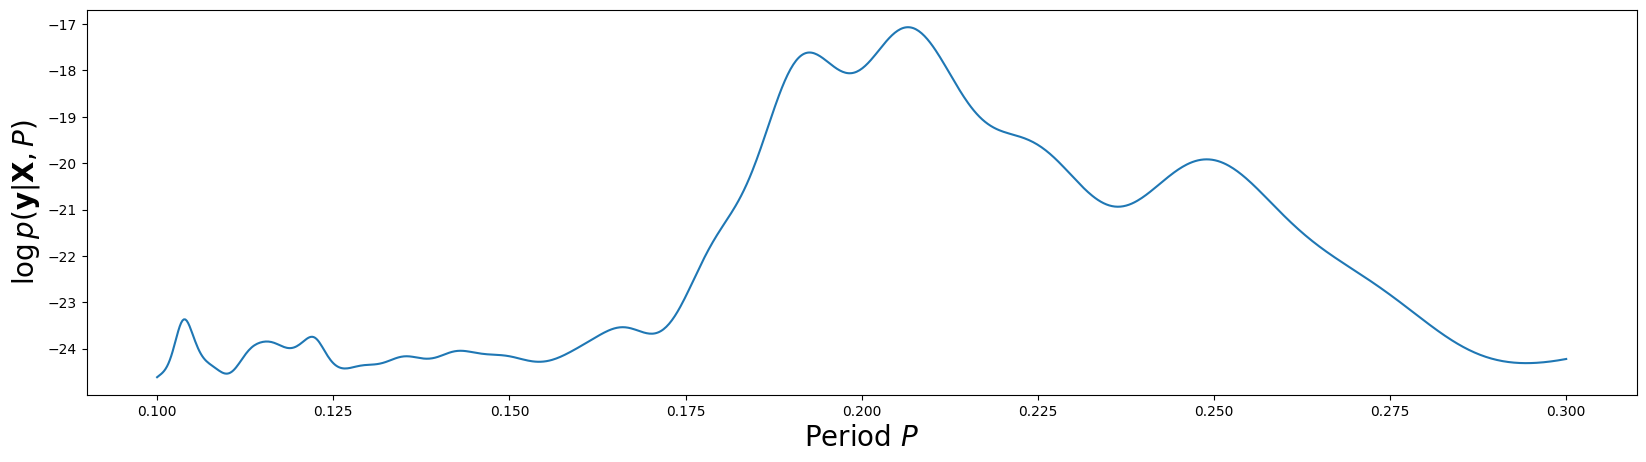

In [13]:
# We will compare the quality of different period choices.
periods = np.linspace(0.1,0.3,1000)
log_likelihoods = np.zeros(periods.shape)

# Let's start by plotting few length scales.
fig, ax = plt.subplots(1, 3, figsize=(20, 5), dpi=100)

for i, period in enumerate([0.1, 0.2, 0.3]):
    # TODO: Use the looped period parameter to initialize the kernel function.
    amplitude_cosine = 2.0
    length_scale = 0.2
    amplitude_se = 2.0
    kernel_function = functools.partial(
    combined_kernel,
    period_cosine=period,
    amplitude_cosine=amplitude_cosine,
    length_scale=length_scale,
    amplitude_se=amplitude_se
    )
    gp = GaussianProcess(kernel_function)
    gp.set_observations(x_obs, y_obs, sigma_w)
    y_pred_mean, y_pred_cov = gp.predict(x)
    y_pred_std = np.sqrt(np.diag(y_pred_cov))
    ax[i].plot(x, y_pred_mean, color = '#99d8c9', label = 'GP Posterior Distribution')
    ax[i].plot(x_obs, y_obs, 'x', color = 'k', label = 'Observed Data', markersize=7)
    ax[i].plot(x, f_true, '--', color = 'k', label = 'True Generative Function')
    ax[i].fill_between(x[:,0], y_pred_mean - 2 * y_pred_std, y_pred_mean + 2 * y_pred_std, 
                       color = '#99d8c9', alpha=0.5)
    ax[i].legend()
    ax[i].set_xlabel('Time')
    ax[i].set_ylabel('f(Time)')
    ax[i].set_ylim([-10,10])
    ax[i].set_title(f'Period = {period}')

# plt.show()

# For each length scale, calculate the log likelihood.
for i, period in enumerate(periods):
    # TODO: Use the looped period parameter to initialize the kernel function.
    amplitude_cosine = 2.0
    length_scale = 0.2
    amplitude_se = 2.0
    kernel_function = functools.partial(
    combined_kernel,
    period_cosine=period,
    amplitude_cosine=amplitude_cosine,
    length_scale=length_scale,
    amplitude_se=amplitude_se
    )
    gp = GaussianProcess(kernel_function)
    gp.set_observations(x_obs, y_obs, sigma_w)
    log_likelihoods[i] = gp.log_likelihood()

plt.figure(figsize=(20,5))
plt.plot(periods, log_likelihoods)
# plt.axvline(0.2, c='k')
plt.xlabel(r'Period $P$', fontsize=20)
plt.ylabel(r'$\log p(\mathbf{y}|\mathbf{X},P)$', fontsize=20)

plt.show()

__What value of the period parameter maximizes the data likelihood? Does this make sense?__

__How would you describe the predictions from $p=0.1$? Too complex or to too simple? Does this make sense?__

In [ ]:
Short answer:

- The cosine kernel encodes correlations by cos(|tau|/P). If P is wrong the model assigns the wrong sign/strength of correlation between points. Example: at the true separation tau=0.2,
    - cos(0.2/0.2) = cos(1) ≈ +0.54 (positive correlation),
    - cos(0.2/0.1) = cos(2) ≈ −0.42 (negative correlation).
    With P=0.1 the kernel anti-correlates points that are actually positively correlated, so the GP extrapolates incorrectly and uncertainty/oscillatory artifacts appear.

- y_pred_std (predictive standard deviation) pattern: low near observed x (observations reduce uncertainty), larger away from data. The periodic oscillations and envelopes in your array come from the cosine part (periodic structure) modulated by the squared-exponential part (smooth envelope). A mismatched period (P=0.1) produces stronger oscillations and sometimes larger variance because wrong-sign correlations reduce the effective information the observations provide.

- Why P=0.2 is best: it matches the data periodicity so the kernel gives correct positive correlations at the relevant lags, lowering posterior variance and producing correct periodic structure. P=0.1 is effectively "too high frequency" (or phase-mismatched), causing the GP to explain data with spurious high-frequency/anti-correlated components (too complex / wrong structure).

Practical remedies: fit/optimize P by maximizing the log-likelihood, use the combined (cosine + SE) kernel so you model both periodicity and amplitude modulation, or add more observations to reduce ambiguity.


In [ ]:
# TODO: Change this cell to markdown and write your answer to the question above.

raise ValueError('Answer the question.')